In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import datetime

In [2]:
# cuda ile çalışıyorsa true döner aksi durumda false
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
firstRunTime=datetime.datetime.now()

In [5]:
# Veri setlerini yükleme
train_df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Csv/cure_the_princess_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Csv/cure_the_princess_validation.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Csv/cure_the_princess_test.csv')

In [6]:
# Veri setlerini işleme için sınıf oluşturuyoruz
class MyDataset(Dataset):
    def __init__(self, df):
        self.inputs = df.drop('Cured', axis=1).values
        self.labels = df['Cured'].values
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
train_dataset = MyDataset(train_df)
val_dataset = MyDataset(val_df)
test_dataset = MyDataset(test_df)

In [8]:
batch_size = 16

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
#Model oluşturuyoruz
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [11]:
input_size=len(train_df.columns) - 1
hidden_size1=100
hidden_size2=50
output_size=len(train_df['Cured'].unique())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

In [12]:
#Loss fonksiyonu belirliyoruz
criterion = nn.CrossEntropyLoss()

#Optimizasyon yöntemi ve parametreleri belirliyoruz
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [13]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0, verbose=False, path='checkpoint.pt', trace_func=print):
        # patience: epoch sayısı - eğer bu sayı boyunca validation loss değeri artarsa eğitim durdurulur
        self.patience = patience
        # delta: validation loss'da önemsiz değişiklikler olarak kabul edilebilecek değer aralığı
        self.delta = delta
        # verbose: kaydedilen checkpoint'ların detaylı loglarının ekrana yazdırılıp yazdırılmayacağı
        self.verbose = verbose
        # path: kaydedilen checkpoint'ların kaydedileceği dosya yolu ve ismi
        self.path = path
         # trace_func: eğitim sırasında logların yazdırılacağı çıktı fonksiyonu
        self.trace_func = trace_func
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # eğitim sırasında her epoch sonunda çağrılır
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # modeli kaydeder ve kaydedilen checkpoint'ın loglarını yazdırır
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)

In [14]:
class L2Regularization(nn.Module):
    def __init__(self, weight_decay):
        super(L2Regularization, self).__init__()
        self.weight_decay = weight_decay

    def forward(self, model):
        l2_reg = torch.tensor(0.).to(device)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l2_reg += torch.norm(param, p=2)**2
        return self.weight_decay * l2_reg


In [15]:
class DropoutRegularization(nn.Module):
    def __init__(self, dropout_prob):
        super(DropoutRegularization, self).__init__()
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.dropout(x)
        return x


In [16]:
torch.manual_seed(190401085)

# Dropout regülasyonu için DropoutRegularization sınıfından nesne oluşturuldu ve dropout oranı 0.5 olarak ayarlandı
dropout_reg = DropoutRegularization(0.5)

# L2 regülasyonu için L2Regularization sınıfından nesne oluşturuldu ve L2 faktörü 1e-5 olarak ayarlandı
l2_reg = L2Regularization(1e-5)

# EarlyStopping sınıfını başlat
early_stopping = EarlyStopping(patience=7, verbose=True)

train_loss_list = [] # train loss listesi
val_loss_list = [] # validation loss listesi

num_epochs = 50

# Her bir epoch'ta dongu
for epoch in range(num_epochs):
    # Model egitim modunda (training mode) olacak
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Her bir batch (yigin) icin dongu
    for i, (inputs, labels) in enumerate(train_loader):
        # Verileri GPU'ya taşı
        inputs, labels = inputs.to(device), labels.to(device)

        # Gradientleri sifirla
        optimizer.zero_grad()

        # Forward pass islemi
        outputs = model(inputs)

        # Loss hesapla
        loss = criterion(outputs, labels)

        # L2 regularization uygula
        l2_loss = l2_reg(model)
        loss += l2_loss   

        # Dropout regularization uygula
        outputs = dropout_reg(outputs)

        # Gradientleri backward işlemi ile hesapla
        loss.backward()

        # Optimize etmek için weights (ağırlıklar) güncelle
        optimizer.step()

        # Toplam loss değerini ve doğru tahmin sayısını güncelle
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Her 100 batchte bir kaybı yazdır
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Train loss'un ortalamasını al ve kaydet
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / train_total
    train_loss_list.append(train_loss)

    # Model degerlendirme modunda (evaluation mode) olacak
    model.eval()

    # Validation veri seti üzerinde degerlendirme
    with torch.no_grad():
        val_loss = 0
        val_correct = 0
        val_total = 0

        # Her bir batch (yigin) için dongu
        for inputs, labels in val_loader:
            # Verileri GPU'ya tasi
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass islemi
            outputs = model(inputs)

            # Loss hesapla
            loss = criterion(outputs, labels)

            # L2 regularization uygula
            l2_loss = l2_reg(model)
            loss += l2_loss   
         
            # Dropout regularization uygula
            outputs = dropout_reg(outputs)

            # Toplam loss degerini ve doğru tahmin sayisini guncelle
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        # Validation loss'un ortalamasını al ve kaydet
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_loss_list.append(val_loss)

    # Her epoch sonunda train loss, train accuracy, validation loss ve validation accuracy'yi yazdır
    print(f'Epoch: {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}% ')

    # Early stopping sınıfını çağırarak, eğitim işleminin devam etmesi gerekip gerekmediğini kontrol et
    early_stopping(val_loss, model)

    # Early stopping aktif hale gelirse eğitim döngüsünden çık
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch: 1/50 - Train Loss: 0.6640 - Train Acc: 51.92% - Val Loss: 0.6162 - Val Acc: 54.14% 
Validation loss decreased (-0.616195 --> 0.616195).  Saving model ...
Epoch: 2/50 - Train Loss: 0.5893 - Train Acc: 57.43% - Val Loss: 0.5630 - Val Acc: 55.10% 
Validation loss decreased (-0.563030 --> 0.563030).  Saving model ...
Epoch: 3/50 - Train Loss: 0.5404 - Train Acc: 58.55% - Val Loss: 0.5098 - Val Acc: 61.15% 
Validation loss decreased (-0.509791 --> 0.509791).  Saving model ...
Epoch: 4/50 - Train Loss: 0.5064 - Train Acc: 57.83% - Val Loss: 0.4685 - Val Acc: 61.46% 
Validation loss decreased (-0.468489 --> 0.468489).  Saving model ...
Epoch: 5/50 - Train Loss: 0.4876 - Train Acc: 58.07% - Val Loss: 0.4565 - Val Acc: 63.06% 
Validation loss decreased (-0.456494 --> 0.456494).  Saving model ...
Epoch: 6/50 - Train Loss: 0.4760 - Train Acc: 56.79% - Val Loss: 0.4754 - Val Acc: 59.55% 
EarlyStopping counter: 1 out of 7
Epoch: 7/50 - Train Loss: 0.4657 - Train Acc: 59.50% - Val Loss: 0.434

In [17]:
new_model = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

# Kaydedilmiş modelin dosya yolunu belirleyin
model_path = '/content/checkpoint.pt'

# En iyi modeli yükleyin
new_model.load_state_dict(torch.load(model_path))

# Yeni modelin performansını değerlendirme modunda (evaluation mode) ayarlayın
new_model.eval()

# Test veri seti değerlendirme
with torch.no_grad():
    predicted_labels = []
    true_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = new_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels += predicted.tolist()
        true_labels += labels.tolist()
        
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Sklearn kütüphanesi ile hesaplanan metrik değerleri yazdırma
print("Accuracy: {:.4f}".format(accuracy_score(true_labels, predicted_labels)))
print("Precision: {:.4f}".format(precision_score(true_labels, predicted_labels)))
print("Recall: {:.4f}".format(recall_score(true_labels, predicted_labels)))
print("F1 Score: {:.4f}".format(f1_score(true_labels, predicted_labels)))


Accuracy: 0.9430
Precision: 0.9550
Recall: 0.9304
F1 Score: 0.9426


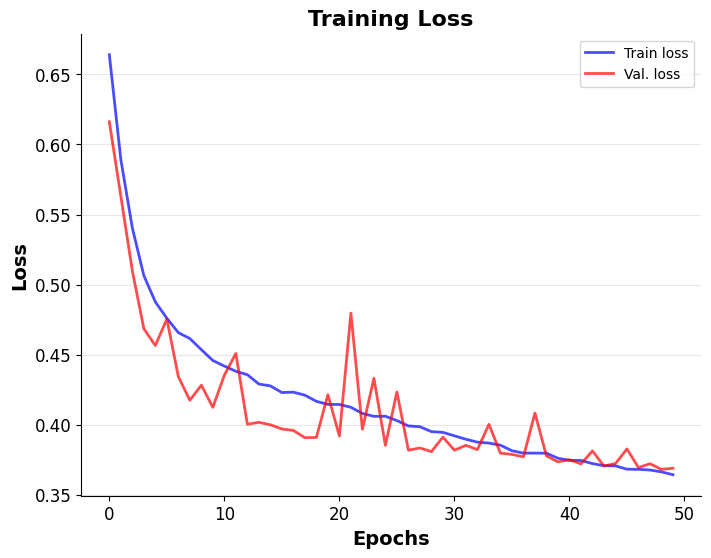

In [18]:
# matplotlib kütüphanesini içe aktarıyoruz
import matplotlib.pyplot as plt

# figür ve eksen objelerini oluşturuyoruz
fig, ax = plt.subplots(figsize=(8,6))

# eğitim kayıp değerlerini mavi renkte, eğitim sırasındaki çıktı kayıplarını gösteren grafiği çiziyoruz
plt.plot(train_loss_list, color='blue', linewidth=2, alpha=0.7, label="Train loss")

# doğrulama (validation) kayıp değerlerini kırmızı renkte, doğrulama sırasındaki çıktı kayıplarını gösteren grafiği çiziyoruz
plt.plot(val_loss_list, color='red', linewidth=2, alpha=0.7, label="Val. loss")

# grafiğin başlığını belirliyoruz
plt.title('Training Loss', fontsize=16, fontweight='bold')

# x ekseni etiketini belirliyoruz
plt.xlabel('Epochs', fontsize=14, fontweight='bold')

# y ekseni etiketini belirliyoruz
plt.ylabel('Loss', fontsize=14, fontweight='bold')

# eksen etiketleri boyutunu ayarlıyoruz
ax.tick_params(axis='both', labelsize=12)

# eksenlerin üst ve sağ taraflarını kaldırıyoruz
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# y ekseni üzerindeki ızgaraların şeffaflığını ayarlıyoruz
ax.grid(axis='y', alpha=0.3)

# grafiğin açıklamasını belirliyoruz
plt.legend()

# grafiği gösteriyoruz
plt.show()


In [19]:
lastRunTime=datetime.datetime.now()
print("İlk Çalışma  :",firstRunTime)
print("Tamamlanma   :",lastRunTime)
print(f"Kodun Çalışma süresi: {device} ",lastRunTime-firstRunTime)

İlk Çalışma  : 2023-04-08 23:25:42.385292
Tamamlanma   : 2023-04-08 23:26:05.627292
Kodun Çalışma süresi: cuda:0  0:00:23.242000
